# Chapter 6 - Working with strings 

## This chapter will cover 
* UTF-8 encoding of Julia strings; byte versus character indexing
* Manipulating strings: interpolation, splitting, using regular expressions, parsing
* Working with symbols
* Using the InlineStrings.jl package to work with fixed-width strings
* Using the PooledArrays.jl package to compress vectors of strings

As an application of string processing, we will analyze movie genres that were given ratings by Twitter users. We want to understand which movie genre is most common and how the relative frequency of this genre changes with the movie year.

We will analyze the movie genre data according to the following steps, which are described in the subsequent sections of this chapter and depicted in figure 6.1:

1. Read in the data in Julia.    
2. Parse the original data to extract the year and genre list for each analyzed movie.
3. Create frequency tables to find which movie genre is most common.
4. Create a plot of popularity of the most common genre by year.


An image depicting the steps that we'll be [taking](https://drek4537l1klr.cloudfront.net/kaminski2/Figures/CH06_F01_Kaminski2.png)

## Download the file

In [2]:
url = "https://raw.githubusercontent.com/sidooms/MovieTweetings/44c525d0c766944910686c60697203cda39305d6/snapshots/10K/movies.dat"

"https://raw.githubusercontent.com/sidooms/MovieTweetings/44c525d0c766944910686c60697203cda39305d6/snapshots/10K/movies.dat"

In [3]:
download(url, "movies.dat")

"movies.dat"

### Basic characteristics of strings in julia

We can interpolate variable in strings by using the '$' operator `println("This is $price American dollers")` 

If we are executing a function/operation we must wrap the code inside curly brackets as per `"This price is $(a + price) American dollers"` 

The newline character can be embedded within the string literal to print a new line and divide the string up

In [6]:
print("This is the first\nthis is the second\nthis is the third")

This is the first
this is the second
this is the third

To actually use the dollar sign '$' character so that it's not interpreted as an interpolation, we have to escape it

In [8]:
print("The price is \$100")

The price is $100

### Avoiding complicated escape combinations 
In instances in which we want to print a string which contains multiple special characters, which should not be interpolated and interpreted as newlines, instead of embedding escape characters amongst the string literal, we can simply prefix the entire string with **raw**, turning the string into a raw literal. For example this would help greatly if we want to pring file paths and the like 

In [9]:
raw"C:\my_folder\my_file.txt"

"C:\\my_folder\\my_file.txt"

The triple quote `"""something"""` is used to create multi-line strings

Let's read the data file line by line 

In [11]:
movies = readlines("movies.dat") 

3096-element Vector{String}:
 "0002844::Fantômas - À l'ombre de la guillotine (1913)::Crime|Drama"
 "0007264::The Rink (1916)::Comedy|Short"
 "0008133::The Immigrant (1917)::Short|Comedy|Drama|Romance"
 "0012349::The Kid (1921)::Comedy|Drama|Family"
 "0013427::Nanook of the North (1922)::Documentary"
 "0014142::The Hunchback of Notre Dame (1923)::Drama|Romance"
 "0014538::Three Ages (1923)::Comedy"
 "0014872::Entr'acte (1924)::Short"
 "0015163::The Navigator (1924)::Action|Comedy"
 "0015324::Sherlock Jr. (1924)::Comedy|Fantasy"
 "0015400::The Thief of Bagdad (1924)::Adventure|Family|Fantasy|Romance"
 "0017925::The General (1926)::Action|Adventure|Comedy|Romance|War"
 "0018773::The Circus (1928)::Comedy|Romance"
 ⋮
 "2638984::Teal Diva (2012)::Documentary|Short"
 "2645104::Romantik komedi 2: Bekarliga veda (2013)::Comedy"
 "2645164::The Hardy Bucks Movie (2013)::Comedy"
 "2646378::The Frankenstein Theory (2013)::Horror|Sci-Fi"
 "2649128::Metro (2013)::Thriller"
 "2670226::Jîn (2013)::Dr

The file used the "::" charactera as string delimiters, for columns, and then the '|' characters for a within column separator e.g. the genres. We should work on the file and format it to make it more consistent and tidy - data sanitation if you will. A few ideas
* Keep the first column as ID
* Split the release year from the movie title
* Parse the genres into an array


Take the first line - subsampling it 

In [107]:
first_line = first(movies)

"0002844::Fantômas - À l'ombre de la guillotine (1913)::Crime|Drama"

What is the type of the data?

In [14]:
typeof(first_line)

String

A string, so we can use split

In [37]:
first_split = split(first_line, [':', '|', '(', ')']) # split using several characters 

8-element Vector{SubString{String}}:
 "0002844"
 ""
 "Fantômas - À l'ombre de la guillotine "
 "1913"
 ""
 ""
 "Crime"
 "Drama"

"You might have noticed that the movies vector has the type Vector{String}, while the movie1_parts vector has the type Vector{SubString{String}}. This is because Julia, for efficiency, when splitting a string with the split function, does not copy the string but instead creates a SubString{String} object that points to the slice of the original string. Having this behavior is safe, as strings in Julia are immutable (we already talked about mutable and immutable types in chapter 4). Therefore, once the string is created, its contents cannot be changed. Creation of a substring of a string is guaranteed to be a safe operation. In your code, if you want to create a SubString{String}, you can use the view function or the @view macro on a String." 

In [59]:
second_split = [] 
for f in first_split 
    if match(r"[A-Za-z0-9]+", f) != nothing
        push!(second_split, f) 
    end 
end 

In [66]:
for f in second_split[4:end]
    println(f)
end 

Crime
Drama


In [120]:
second_split

5-element Vector{Any}:
 "0002844"
 "Fantômas - À l'ombre de la guillotine "
 "1913"
 "Crime"
 "Drama"

How might we parse the lines and get a nice map of each column? This is my own function, which doesn't rely on just using regex, as bogumils does, and so it is dirtier and less elegant. 

In [200]:
function parseline_1(line::AbstractString)
    first_split = split(line, [':', '|', '(', ')'])
    second_split = []
    for f in first_split
        if match(r"[A-Za-z0-9]+", f) != nothing
            push!(second_split, f)
        end 
    end 
    return (id=second_split[1], 
            name=second_split[2], 
            year=second_split[3], 
            genre=second_split[4:end])
end 

parseline_1 (generic function with 1 method)

In [136]:
parsed_columns = parseline(first_line)

(id = "0002844", name = "Fantômas - À l'ombre de la guillotine ", year = "1913", genre = Any["Crime", "Drama"])

In [151]:
parsed_columns.id

"0002844"

Another variant - this will simply print the indices without assigning them to any variable

In [152]:
function parseline_2(line::AbstractString)
    first_split = split(line, [':', '|', '(', ')'])
    second_split = []
    for f in first_split
        if match(r"[A-Za-z0-9]+", f) != nothing
            push!(second_split, f)
        end 
    end 
    return (second_split[1], 
            second_split[2], 
            second_split[3], 
            second_split[4:end])
end 

parseline_2 (generic function with 1 method)

In [160]:
tmp_array = []
for lines in readlines("movies.dat")
    push!(tmp_array, parseline_2(lines))
end 
tmp_array

3096-element Vector{Any}:
 ("0002844", "Fantômas - À l'ombre de la guillotine ", "1913", Any["Crime", "Drama"])
 ("0007264", "The Rink ", "1916", Any["Comedy", "Short"])
 ("0008133", "The Immigrant ", "1917", Any["Short", "Comedy", "Drama", "Romance"])
 ("0012349", "The Kid ", "1921", Any["Comedy", "Drama", "Family"])
 ("0013427", "Nanook of the North ", "1922", Any["Documentary"])
 ("0014142", "The Hunchback of Notre Dame ", "1923", Any["Drama", "Romance"])
 ("0014538", "Three Ages ", "1923", Any["Comedy"])
 ("0014872", "Entr'acte ", "1924", Any["Short"])
 ("0015163", "The Navigator ", "1924", Any["Action", "Comedy"])
 ("0015324", "Sherlock Jr. ", "1924", Any["Comedy", "Fantasy"])
 ("0015400", "The Thief of Bagdad ", "1924", Any["Adventure", "Family", "Fantasy", "Romance"])
 ("0017925", "The General ", "1926", Any["Action", "Adventure", "Comedy", "Romance", "War"])
 ("0018773", "The Circus ", "1928", Any["Comedy", "Romance"])
 ⋮
 ("2638984", "Teal Diva ", "2012", Any["Documentary", "S

### Load this into a dataframe using some bogumil magic from 
https://stackoverflow.com/questions/72957438/how-to-convert-a-vector-of-vectors-into-a-dataframe-in-julia-without-for-loop 

In [170]:
df_one = DataFrame([getindex.(tmp_array, i) for i in 1:4], :auto, copycols=false)

Row,x1,x2,x3,x4
,SubStrin…,SubStrin…,SubStrin…,Array…
1,0002844,Fantômas - À l'ombre de la guillotine,1913,"Any[""Crime"", ""Drama""]"
2,0007264,The Rink,1916,"Any[""Comedy"", ""Short""]"
3,0008133,The Immigrant,1917,"Any[""Short"", ""Comedy"", ""Drama"", ""Romance""]"
4,0012349,The Kid,1921,"Any[""Comedy"", ""Drama"", ""Family""]"
5,0013427,Nanook of the North,1922,"Any[""Documentary""]"
6,0014142,The Hunchback of Notre Dame,1923,"Any[""Drama"", ""Romance""]"
7,0014538,Three Ages,1923,"Any[""Comedy""]"
8,0014872,Entr'acte,1924,"Any[""Short""]"
9,0015163,The Navigator,1924,"Any[""Action"", ""Comedy""]"


Jesus, it actually worked? How? 
Using the broadcasting funtion of get index, we create a comphrension where we iterate through the columns 1 to 4 of the vector, sequentially loading the column, and allowing DataFrames to automatically use these values are input **:auto** option 

In [89]:
column_names = ["id", "title", "year", "genre"] 

4-element Vector{String}:
 "id"
 "title"
 "year"
 "genre"

In [171]:
df_two = rename(df_one, column_names)

Row,id,title,year,genre
,SubStrin…,SubStrin…,SubStrin…,Array…
1,0002844,Fantômas - À l'ombre de la guillotine,1913,"Any[""Crime"", ""Drama""]"
2,0007264,The Rink,1916,"Any[""Comedy"", ""Short""]"
3,0008133,The Immigrant,1917,"Any[""Short"", ""Comedy"", ""Drama"", ""Romance""]"
4,0012349,The Kid,1921,"Any[""Comedy"", ""Drama"", ""Family""]"
5,0013427,Nanook of the North,1922,"Any[""Documentary""]"
6,0014142,The Hunchback of Notre Dame,1923,"Any[""Drama"", ""Romance""]"
7,0014538,Three Ages,1923,"Any[""Comedy""]"
8,0014872,Entr'acte,1924,"Any[""Short""]"
9,0015163,The Navigator,1924,"Any[""Action"", ""Comedy""]"


In [68]:
using DataFrames

In [92]:
sample_df = DataFrame([name => [] for name in column_names])

Row,id,title,year,genre
,Any,Any,Any,Any


### How did Bogumil do it in the course? 

In [231]:
function parseline(line::AbstractString)
   parts = split(line, "::")
   m = match(r"(.+) \((\d{4})\)", parts[2])
   return (id=parts[1],
           name=m[1],
           year=parse(Int, m[2]),
           genres=split(parts[3], "|"))
end

parseline (generic function with 1 method)

Instead of creating loops like I did, he split the parts using the '::' separator, and then used a regex to separaterly split the year from the title from the first splitting procedure. After this he assigned the various parts to variables. 

## How String indexing is done
### UTF-8 encoding of strings in Julia

UTF-8 is a character encoding standard which is most commonly used today. It defines the how the character in encoded in bytes of sizes 1:4, with some characters being encoded with 1 byte, and others with 2, 3 or even 4 bytes. Why is this important and practical? In julia, when performing indexing on a string, julia indexes based on the byte size, rather than on the character size itself. Here is an example

In [173]:
z = "Fantômas"

"Fantômas"

This string contains a special character on 'o', so taking a look at the literal length of the string, we can see that it's 8 characters long. If we take a look at it's length in UTF-8 encoding, meaning, its byte length using the **codeunits()** function

In [181]:
length(codeunits(z))

9

We can see that it's 9 bytes long?! How come? The special 'o' character is represented by two bytes, and so it takes up bytes [5,6]. Try indexing from literal 1:6 and see if it let's you. 

In [183]:
z[1:6]

LoadError: StringIndexError: invalid index [6], valid nearby indices [5]=>'ô', [7]=>'m'

Nope. Now try from 1:7 and 1:5

In [185]:
z[1:7]

"Fantôm"

In [186]:
z[1:5]

"Fantô"

We can imagine the inconsistencies and problems this can introduce to our code if we rely on indexing strings in this format. **"Therefore, you must always check when using a function to see whether it works with byte indices or character indices. You have already seen that indexing using square brackets uses byte indexing and that the function first uses character counts. In my blog post “The String, or There and Back Again” (http://mng.bz/XaW1), I have created a glossary of the most commonly used functions when working with strings, including the kinds of indexing they use."**

In [189]:
for i in eachindex(z)
          println(i, ": ", z[i])
      end

1: F
2: a
3: n
4: t
5: ô
7: m
8: a
9: s


The function **first()** with alternatively use character-literal indexing on strings, rather than byte indexing

In [191]:
first(z, 6)

"Fantôm"

**"In data science workflows, you will most commonly want to operate on strings using character counts, not byte indexing. Therefore, it is recommended that you do not index into strings using square brackets.
"**

### ASCII string
In one case, byte and character indexing are guaranteed to produce the same result. This happens when your string consists only of ASCII characters. The most important examples of such characters are the digits 0 to 9, lowercase letters a to z, uppercase letters A to Z, and common symbols like !, +, -, *, ), and (. Generally, any character that can be typed without using meta keys on a standard US keyboard is an ASCII character.

An important feature of ASCII characters is that they are always represented by a single byte in UTF-8 encoding. In Julia, you can easily check whether your string consists of only ASCII characters by using the isascii function:


In [192]:
isascii("abcd")

true

In [193]:
isascii("∀ x: x≥0")

false

## Analyzing genre frequency in movies
We'll be creating a basic frequency table, as well and looking at how the top genres change from year to year. 

### Finding common movie genres

In [228]:
movies_vector = parseline.(movies) 

3096-element Vector{@NamedTuple{id::SubString{String}, name::SubString{String}, year::Int64, genres::Vector{SubString{String}}}}:
 (id = "0002844", name = "Fantômas - À l'ombre de la guillotine", year = 1913, genres = ["Crime", "Drama"])
 (id = "0007264", name = "The Rink", year = 1916, genres = ["Comedy", "Short"])
 (id = "0008133", name = "The Immigrant", year = 1917, genres = ["Short", "Comedy", "Drama", "Romance"])
 (id = "0012349", name = "The Kid", year = 1921, genres = ["Comedy", "Drama", "Family"])
 (id = "0013427", name = "Nanook of the North", year = 1922, genres = ["Documentary"])
 (id = "0014142", name = "The Hunchback of Notre Dame", year = 1923, genres = ["Drama", "Romance"])
 (id = "0014538", name = "Three Ages", year = 1923, genres = ["Comedy"])
 (id = "0014872", name = "Entr'acte", year = 1924, genres = ["Short"])
 (id = "0015163", name = "The Navigator", year = 1924, genres = ["Action", "Comedy"])
 (id = "0015324", name = "Sherlock Jr.", year = 1924, genres = ["Comedy

Create a single vector containing all of the genres from the movies.dat

In [229]:
all_genres = String[]

String[]

In [232]:
for lines in movies_vector
    append!(all_genres, lines.genres)
end

In [233]:
all_genres

8121-element Vector{String}:
 "Crime"
 "Drama"
 "Comedy"
 "Short"
 "Short"
 "Comedy"
 "Drama"
 "Romance"
 "Comedy"
 "Drama"
 "Family"
 "Documentary"
 "Drama"
 ⋮
 "Short"
 "Comedy"
 "Drama"
 "Family"
 "Short"
 "Comedy"
 "Short"
 "Drama"
 "Family"
 "Short"
 "Drama"
 "Short"

Create a basic frequency mapping using the StatsBase function **countmap()** 

In [226]:
using StatsBase

In [234]:
countmap(all_genres)

Dict{String, Int64} with 25 entries:
  "Family"      => 222
  "Short"       => 46
  "Documentary" => 126
  "War"         => 126
  "Action"      => 635
  "Adventure"   => 443
  "Mystery"     => 294
  "History"     => 125
  "Biography"   => 166
  "Sport"       => 84
  "Sci-Fi"      => 305
  "Thriller"    => 910
  "Comedy"      => 1001
  "Fantasy"     => 278
  "Drama"       => 1583
  "News"        => 4
  "Music"       => 83
  "Animation"   => 137
  "Western"     => 35
  "Horror"      => 325
  "Romance"     => 558
  "Film-Noir"   => 13
  ""            => 14
  "Crime"       => 550
  "Musical"     => 58

In [235]:
using Plots

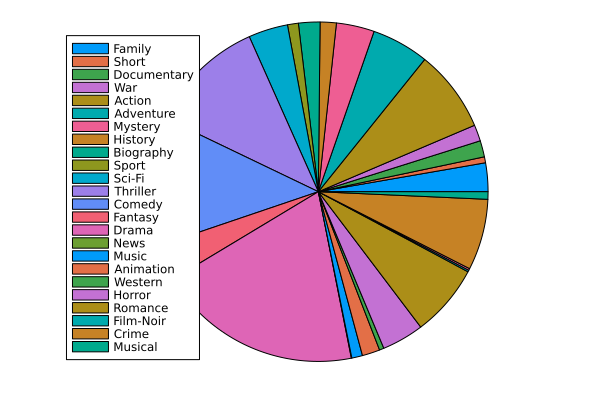

In [239]:
pie(countmap(all_genres))

Ugly!!!! Not acceptable at all. 

Now create a frequency table using the FreqTable package

In [ ]:
using Pkg; Pkg.add("FreqTables") ; using FreqTables

In [248]:
sort(freqtable(all_genres)) 

25-element Named Vector{Int64}
Dim1        │ 
────────────┼─────
News        │    4
Film-Noir   │   13
            │   14
Western     │   35
Short       │   46
Musical     │   58
Music       │   83
Sport       │   84
History     │  125
Documentary │  126
War         │  126
⋮                ⋮
Fantasy     │  278
Mystery     │  294
Sci-Fi      │  305
Horror      │  325
Adventure   │  443
Crime       │  550
Romance     │  558
Action      │  635
Thriller    │  910
Comedy      │ 1001
Drama       │ 1583

**Pay attention to the frequency table Type - the Named Vector (NamedArray). Each type has it's own idiosyncracies and thus factor into design considerations**

### Does genre frequency change much across years?
Let's take a look. We'll look at creating binary variables for absence/presence of a movie in a particular year, and then proportionality tables which calculate percentages for us

#### Extract the year of each movie to a vector 

In [250]:
years = [line.year for line in movies_vector]

3096-element Vector{Int64}:
 1913
 1916
 1917
 1921
 1922
 1923
 1923
 1924
 1924
 1924
 1924
 1926
 1928
    ⋮
 2012
 2013
 2013
 2013
 2013
 2013
 2010
 2012
 2013
 2013
 2013
 2013

In [252]:
has_drama = ["Drama" in line.genres for line in movies_vector]

3096-element Vector{Bool}:
 1
 0
 1
 1
 0
 1
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 1
 0
 1
 0
 1
 1
 0

In [255]:
drama_prop = proptable(years, has_drama; margins=1)

93×2 Named Matrix{Float64}
Dim1 ╲ Dim2 │    false      true
────────────┼───────────────────
1913        │      0.0       1.0
1916        │      1.0       0.0
1917        │      0.0       1.0
1921        │      0.0       1.0
1922        │      1.0       0.0
1923        │      0.5       0.5
1924        │      1.0       0.0
1926        │      1.0       0.0
1928        │      1.0       0.0
1929        │      1.0       0.0
1930        │ 0.333333  0.666667
⋮                    ⋮         ⋮
2003        │ 0.533333  0.466667
2004        │ 0.438095  0.561905
2005        │ 0.387931  0.612069
2006        │ 0.426357  0.573643
2007        │ 0.492063  0.507937
2008        │ 0.424051  0.575949
2009        │ 0.432432  0.567568
2010        │ 0.451754  0.548246
2011        │ 0.484472  0.515528
2012        │ 0.577017  0.422983
2013        │ 0.623529  0.376471

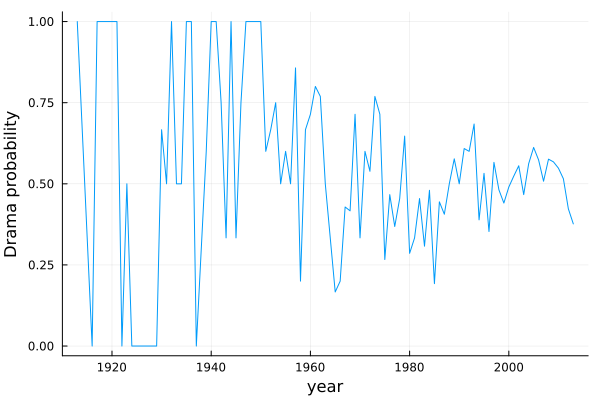

In [260]:
plot(names(drama_prop, 1), drama_prop[:, 2]; legend=false,
           xlabel="year", ylabel="Drama probability")

### Exercise 6.1
Create a plot of the number of movies by year, using the years variable. 

- Create a dict mapping year to number of drama movies?
- Subset the original movies vector to include only rows containing drama as a genre? then just count number of times each years appears?

In [278]:
#dict = Dict() 
#for line in movies_vector
#    Dict#
#
#    countmap(movies_vector.year)

In [272]:
all_years = Int64[]

Int64[]

In [273]:
for line in movies_vector
    if "Drama" ∈ line.genres
        append!(all_years, line.year)
    end 
end 

In [276]:
mapped_years = countmap(all_years)

Dict{Int64, Int64} with 86 entries:
  1923 => 1
  1985 => 5
  1953 => 3
  2004 => 59
  1956 => 3
  2002 => 40
  1952 => 2
  1963 => 3
  1964 => 3
  1967 => 3
  1948 => 3
  2001 => 33
  1943 => 1
  2013 => 32
  1965 => 1
  1942 => 3
  1991 => 14
  1976 => 7
  1944 => 3
  1941 => 2
  1957 => 6
  1988 => 17
  2008 => 91
  1955 => 3
  1932 => 1
  ⋮    => ⋮

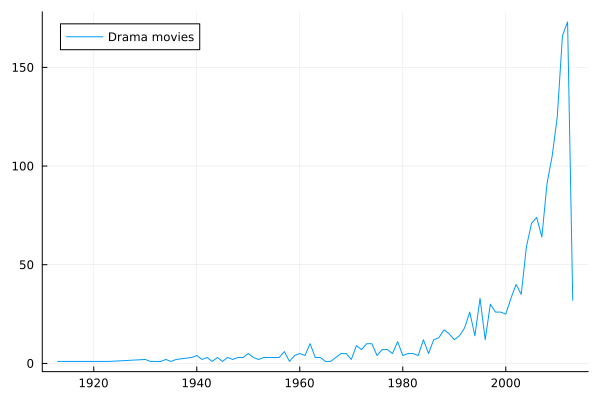

In [304]:
plot(mapped_years, label = "Drama movies")

Overall total movies produced on top of this graph 

In [301]:
all_movies = []

Any[]

In [302]:
for lines in movies_vector
    append!(all_movies, lines.year)
end 

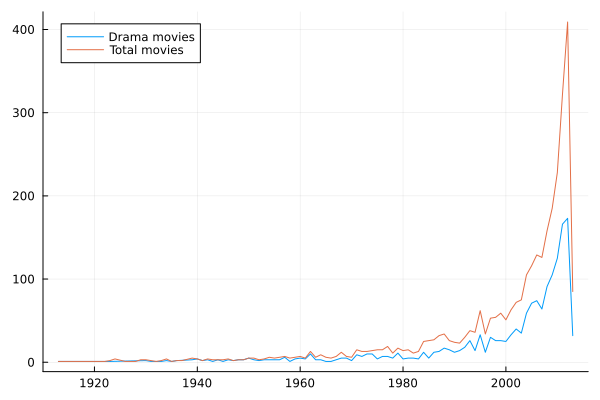

In [305]:
plot!(countmap(all_movies), labels = "Total movies")

## Using Symbols 
Symbols are specific Types in Julia which have several performance advantages when used in the correct context. Symbols are stored within Julia in a 'pool' and indexed for the remainder of the session. We don't use them for much aside from comparisons for equality, and so they can be used conveniently in data science workflows as non-mutable labels-category tags and so on. 

Create a simple symbol 

In [308]:
s1 = Symbol("x") 

:x

Notice the ":" prefix of the symbol 

This will concatenate the two elements into a single symbol

In [309]:
s3 = Symbol("x", 1) #

:x1

We can also easily create one by simply writing `:x1`, but this wont work on intergers/numbers, and there must not be any spaces between strings

In [312]:
:x1

:x1

In [314]:
typeof(:1) 

Int64

Symbols may look like Strings but they are not, their supertype is not AbstractString, so all the operations we can perform on Strings will not work. 

In [316]:
supertype(Symbol)

Any

**"The point is that an equality comparison for symbols is fast, much faster than testing strings for equality. The next listing shows a simple benchmark, in which we look for a value in a vector of one million elements."**

In [317]:
using BenchmarkTools

In [318]:
str = string.("x", 1:10^6)

1000000-element Vector{String}:
 "x1"
 "x2"
 "x3"
 "x4"
 "x5"
 "x6"
 "x7"
 "x8"
 "x9"
 "x10"
 "x11"
 "x12"
 "x13"
 ⋮
 "x999989"
 "x999990"
 "x999991"
 "x999992"
 "x999993"
 "x999994"
 "x999995"
 "x999996"
 "x999997"
 "x999998"
 "x999999"
 "x1000000"

In [319]:
symb = Symbol.(str)

1000000-element Vector{Symbol}:
 :x1
 :x2
 :x3
 :x4
 :x5
 :x6
 :x7
 :x8
 :x9
 :x10
 :x11
 :x12
 :x13
 ⋮
 :x999989
 :x999990
 :x999991
 :x999992
 :x999993
 :x999994
 :x999995
 :x999996
 :x999997
 :x999998
 :x999999
 :x1000000

In [320]:
@btime "x" in $str

  2.612 ms (0 allocations: 0 bytes)


false

In [321]:
@btime :x in $symb

  323.069 μs (0 allocations: 0 bytes)


false

Indexing into a symbol vector is much quicker - performing lookups and so forth. 

You might ask how this is achieved. The trick is that Julia internally keeps a global pool of all symbols. If you introduce a new Symbol, Julia first checks whether it is already present in this pool, and if so, Julia reuses it. Therefore, when you compare two symbols, you can compare their address in memory without having to check their content.

**Because the symbols are stored in this pool of memory until the end of the session, if we create many many symbols, this can cause memory disturbances, and so this should be kept in mind**

## Fixed with string types for improved performance
I'm sure that we've all created a dataframe in which the values of a particular variable only take up a fixed number of characters, say, postcodes which are 5 digits long, or isbn10 numbers which are 10 long, or even addresses which maybe 120 characters long at most. In these instances, we can restrict the length of the String Type to this predefine BYTE limit, and thus maximize performance. Remember, it is indexed based on byte length in UTF-8, not literal character length. 

There are several fixed-with String types: 1, 3, 7, 15, 31, 63, 127 and 255. 

The package InlineStrings can help us work with these strings in a nice and clean way

In [323]:
Pkg.add("InlineStrings")

   Resolving package versions...
    Updating `~/.julia/environments/v1.10/Project.toml`
  [842dd82b] + InlineStrings v1.4.0
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [324]:
using InlineStrings

Let's allow the **InlineString()** and **inlinestrings** function to automatically detect the appropriate StringN length 

In [325]:
s1 = InlineString("x") 

"x"

In [326]:
typeof(s1)

String1

In [327]:
sv = inlinestrings(["The", "quick", "brown", "fox", "jumps",
                          "over", "the", "lazy", "dog"])

9-element Vector{String7}:
 "The"
 "quick"
 "brown"
 "fox"
 "jumps"
 "over"
 "the"
 "lazy"
 "dog"

We can see that s1 requires only a String1, whereas sv requires a String7, due to the varying sizes of the different elements. 

Let's do an experiment to showcase the performance advantages. We'll create a long vector of random strings of length 3, and then another vector of the same strings converted to String3 types, and then we'll sort the and do some benchmarks. 

In [328]:
using Random

In [329]:
string_basic = [randstring(3) for i in 1:10^6] 

1000000-element Vector{String}:
 "HFC"
 "WV7"
 "PCf"
 "H2X"
 "h6Q"
 "gwL"
 "ZhG"
 "KRK"
 "opj"
 "OzO"
 "25v"
 "zbH"
 "647"
 ⋮
 "si1"
 "m1N"
 "Zgb"
 "xG8"
 "ayx"
 "iC0"
 "Z1m"
 "TkR"
 "Uqu"
 "WHB"
 "Uks"
 "hgq"

In [330]:
string_three = inlinestrings(string_basic)

1000000-element Vector{String3}:
 "HFC"
 "WV7"
 "PCf"
 "H2X"
 "h6Q"
 "gwL"
 "ZhG"
 "KRK"
 "opj"
 "OzO"
 "25v"
 "zbH"
 "647"
 ⋮
 "si1"
 "m1N"
 "Zgb"
 "xG8"
 "ayx"
 "iC0"
 "Z1m"
 "TkR"
 "Uqu"
 "WHB"
 "Uks"
 "hgq"

In [334]:
@btime sort(string_three)

  6.740 ms (6 allocations: 7.65 MiB)


1000000-element Vector{String3}:
 "000"
 "000"
 "000"
 "000"
 "000"
 "000"
 "001"
 "001"
 "001"
 "002"
 "002"
 "002"
 "003"
 ⋮
 "zzx"
 "zzx"
 "zzx"
 "zzy"
 "zzy"
 "zzy"
 "zzy"
 "zzz"
 "zzz"
 "zzz"
 "zzz"
 "zzz"

In [333]:
@btime sort(string_basic)

  216.979 ms (4 allocations: 15.26 MiB)


1000000-element Vector{String}:
 "000"
 "000"
 "000"
 "000"
 "000"
 "000"
 "001"
 "001"
 "001"
 "002"
 "002"
 "002"
 "003"
 ⋮
 "zzx"
 "zzx"
 "zzx"
 "zzy"
 "zzy"
 "zzy"
 "zzy"
 "zzz"
 "zzz"
 "zzz"
 "zzz"
 "zzz"

What is the memory footprint?

In [336]:
Base.summarysize(string_basic)

19000040

In [335]:
Base.summarysize(string_three)

4000040

19000040 vs 4000040 

# Exercise 6.2
Using the s1 vector from listing 6.7, create the s3 vector consisting of symbols representing the same strings contained in the s1 vector. Next, benchmark how fast you can sort the s3 vector. Finally, benchmark how fast you can de-duplicate the s1, s2, and s3 vectors by using the unique function.

```julia
string_basic = [randstring(3) for i in 1:10^6]; 
string_three = inlinestrings(string_basic)
```

In [337]:
s3 = Symbol.(string_basic)

1000000-element Vector{Symbol}:
 :HFC
 :WV7
 :PCf
 :H2X
 :h6Q
 :gwL
 :ZhG
 :KRK
 :opj
 :OzO
 Symbol("25v")
 :zbH
 Symbol("647")
 ⋮
 :si1
 :m1N
 :Zgb
 :xG8
 :ayx
 :iC0
 :Z1m
 :TkR
 :Uqu
 :WHB
 :Uks
 :hgq

In [338]:
@btime sort(s3)

  165.970 ms (4 allocations: 15.26 MiB)


1000000-element Vector{Symbol}:
 Symbol("000")
 Symbol("000")
 Symbol("000")
 Symbol("000")
 Symbol("000")
 Symbol("000")
 Symbol("001")
 Symbol("001")
 Symbol("001")
 Symbol("002")
 Symbol("002")
 Symbol("002")
 Symbol("003")
 ⋮
 :zzx
 :zzx
 :zzx
 :zzy
 :zzy
 :zzy
 :zzy
 :zzz
 :zzz
 :zzz
 :zzz
 :zzz

In [339]:
@btime unique(string_basic)

  40.564 ms (49 allocations: 10.46 MiB)


234722-element Vector{String}:
 "HFC"
 "WV7"
 "PCf"
 "H2X"
 "h6Q"
 "gwL"
 "ZhG"
 "KRK"
 "opj"
 "OzO"
 "25v"
 "zbH"
 "647"
 ⋮
 "ZSo"
 "x45"
 "uqK"
 "x6i"
 "qTL"
 "YvQ"
 "CLx"
 "zK1"
 "Anp"
 "LBh"
 "DdD"
 "s8g"

In [341]:
@btime unique(string_three)

  22.712 ms (48 allocations: 6.16 MiB)


234722-element Vector{String3}:
 "HFC"
 "WV7"
 "PCf"
 "H2X"
 "h6Q"
 "gwL"
 "ZhG"
 "KRK"
 "opj"
 "OzO"
 "25v"
 "zbH"
 "647"
 ⋮
 "ZSo"
 "x45"
 "uqK"
 "x6i"
 "qTL"
 "YvQ"
 "CLx"
 "zK1"
 "Anp"
 "LBh"
 "DdD"
 "s8g"

In [340]:
@btime unique(s3) 

  16.843 ms (49 allocations: 10.46 MiB)


234722-element Vector{Symbol}:
 :HFC
 :WV7
 :PCf
 :H2X
 :h6Q
 :gwL
 :ZhG
 :KRK
 :opj
 :OzO
 Symbol("25v")
 :zbH
 Symbol("647")
 ⋮
 :ZSo
 :x45
 :uqK
 :x6i
 :qTL
 :YvQ
 :CLx
 :zK1
 :Anp
 :LBh
 :DdD
 :s8g

## Compressing vectors of Strings with PooledArrays.jl 
We may be working with large datasets consisting of millions of rows of data, typically stored in a text file as a vector - vectors of strings. When in the millions of rows, with potentially multiple files, storage-memory considerations need to be accounted for under the banner of efficiency. Storing our vector of strings as pooled arrays is a good option

Create a large text file with a million rows

In [342]:
open("iris.txt", "w") do io
    for i in 1:10^6
        println(io, "Iris setosa")
        println(io, "Iris virginica")
        println(io, "Iris versicolor")
    end
end

Now let's open the file

In [354]:
isfile("iris.txt")

true

In [355]:
uncompressed = readlines("iris.txt") 

3000000-element Vector{String}:
 "Iris setosa"
 "Iris virginica"
 "Iris versicolor"
 "Iris setosa"
 "Iris virginica"
 "Iris versicolor"
 "Iris setosa"
 "Iris virginica"
 "Iris versicolor"
 "Iris setosa"
 "Iris virginica"
 "Iris versicolor"
 "Iris setosa"
 ⋮
 "Iris setosa"
 "Iris virginica"
 "Iris versicolor"
 "Iris setosa"
 "Iris virginica"
 "Iris versicolor"
 "Iris setosa"
 "Iris virginica"
 "Iris versicolor"
 "Iris setosa"
 "Iris virginica"
 "Iris versicolor"

Load up PooledArrays

In [356]:
Pkg.add("PooledArrays") ; using PooledArrays

   Resolving package versions...
    Updating `~/.julia/environments/v1.10/Project.toml`
  [2dfb63ee] + PooledArrays v1.4.3
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


Load in the uncompressed vector as a PooledArray

In [357]:
compressed = PooledArray(uncompressed) 

3000000-element PooledVector{String, UInt32, Vector{UInt32}}:
 "Iris setosa"
 "Iris virginica"
 "Iris versicolor"
 "Iris setosa"
 "Iris virginica"
 "Iris versicolor"
 "Iris setosa"
 "Iris virginica"
 "Iris versicolor"
 "Iris setosa"
 "Iris virginica"
 "Iris versicolor"
 "Iris setosa"
 ⋮
 "Iris setosa"
 "Iris virginica"
 "Iris versicolor"
 "Iris setosa"
 "Iris virginica"
 "Iris versicolor"
 "Iris setosa"
 "Iris virginica"
 "Iris versicolor"
 "Iris setosa"
 "Iris virginica"
 "Iris versicolor"

What are there respective memory footprints?

In [358]:
Base.summarysize(uncompressed)

88000040

In [359]:
Base.summarysize(compressed)

12000600

Now that's a lot smaller

In [360]:
12000600 / 88000040 

0.13637039255891248

13% of the uncompressed size - impressive

But how is this magic functioning - how's it doing it's job? 